## This notebook is to solve the formulation suggested by Prof. Callies

In [28]:
import P
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import casadi as ca
import pandas as pd

In [505]:
from sfov_lookup import build_sfov_np

csv_path = "./sfov_lookup.csv"
sfov_fun, s_max = build_sfov_np(csv_path)

# Usage of fov caculator:
print("sfov(100) =", float(sfov_fun(100)))
print("sfov([0, 50, 100]) =", sfov_fun([0, 50, 100]))

sfov(100) = 300.0
sfov([0, 50, 100]) = [200. 250. 300.]


In [503]:
def find_nearest_multiple_of_three(number):
    """
    Given a real number, find the nearest multiple of three to it.

    Args:
        number (float or int): The real number.

    Returns:
        int: The multiple of three closest to the given number.
    """
    # Calculate the remainder when the number is divided by 3
    remainder = number % 3

    if remainder == 0:
        return int(number)
    else:
        # Option 1: Round down to the nearest multiple of 3
        lower_multiple = int(number - remainder)
        
        # Option 2: Round up to the nearest multiple of 3
        # If remainder is positive, 3 - remainder gives the distance to the next multiple
        upper_multiple = int(number + (3 - remainder))

        # Compare distances and return the closer one
        if abs(number - lower_multiple) <= abs(number - upper_multiple):
            return lower_multiple
        else:
            return upper_multiple

In [517]:
##define the small section of the track
s0=3060
s_end=3360
ds=3

##define sj, the points needs to check safety
sj=np.array([3120, 3180])

##define the fov
def fov(s):
    s_fov=sfov_fun(s)
    s_fov=find_nearest_multiple_of_three(s_fov)
    return s_fov

In [518]:
##print the length of FOV
print([fov(s)-s for s in sj])

[135, 93]


In [519]:
##==car parameter==##
car_param = {
    "m": 1500,          # mass [kg]
    "g": 9.81,          # gravity [m/s^2]
    "mu_roll": 0.008,   # rolling resistance coefficient
    "mu": 1,            # friction coefficient
    "F_MAX": 2000,      # maximum driving force [N]
    "F_MIN": -13200,    # maximum braking force [N]
    "delta_MAX": np.pi / 6, # maximum steering angle [rad]
    "J_zz": 3000,       # yaw inertia [kg*m^2]
    "l_f": 1.5,         # distance from CoG to front axle [m]
    "l_r": 1.5,         # distance from CoG to rear axle [m]
    "w_f": 1.2,         # front track width [m]
    "w_r": 1.2          # rear track width [m]
}

      # x_m        y_m  w_tr_right_m  w_tr_left_m
0 -0.320123   1.087714         5.739        5.932
1  0.168262   6.062191         5.735        5.929
2  0.656139  11.036647         5.731        5.926
3  1.143549  16.011082         5.727        5.923
4  1.630535  20.985493         5.723        5.920


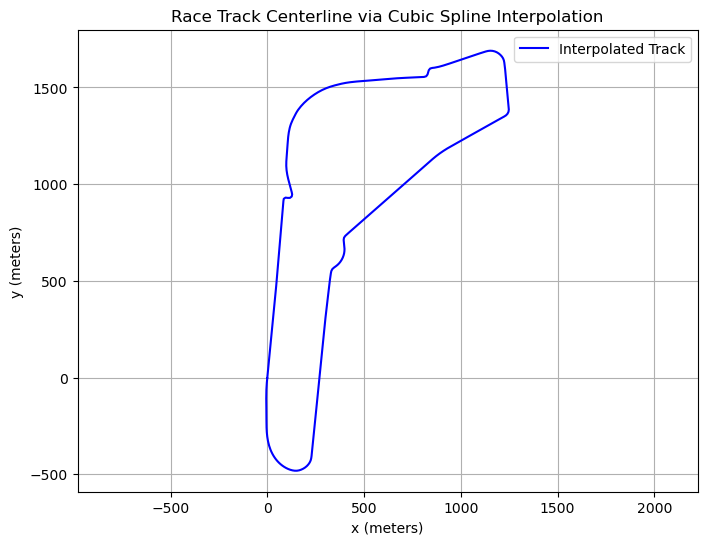

In [520]:
##==load track kappa==##
# 1. set file path
file_path = "Monza.csv"

# 2. read csv file
df = pd.read_csv(file_path)

# 3. look head
print(df.head())

# 4. rename the first row
##df.rename(columns={'# x_m': 'x_m'}, inplace=True)

# 5. read the columns
x = df['# x_m'].values
y = df['y_m'].values
w_left = df['w_tr_left_m'].values
w_right = df['w_tr_right_m'].values

# Step 1: Compute arclengths
s = np.zeros(len(x))
s[1:] = np.cumsum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
s_max=s[-1] #the length of the track

# Step 2: Create cubic spline interpolators
x_spline = CubicSpline(s, x)
y_spline = CubicSpline(s, y)

# Step 3: Get the first and second derivative of the parameteriation
dx_ds = x_spline.derivative(1)
d2x_ds2 = x_spline.derivative(2)
dy_ds = y_spline.derivative(1)
d2y_ds2 = y_spline.derivative(2)

## Generate interpolated values for plotting
s_query = np.linspace(0, s_max, 500)
x_interp = x_spline(s_query)
y_interp = y_spline(s_query)

## Plot the spline
plt.figure(figsize=(8, 6))
plt.plot(x_interp, y_interp, label='Interpolated Track', color='blue')
##plt.plot(x, y, 'ro', label='Original Points')
plt.axis('equal')
plt.title('Race Track Centerline via Cubic Spline Interpolation')
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.legend()
plt.grid(True)
plt.show()

# output parameterisation and curvature as a casadi instance
x_ref = ca.interpolant('x_ref', 'linear', [s_query], x_interp)
y_ref = ca.interpolant('y_ref', 'linear', [s_query], y_interp)
kappa_ref_ = dx_ds(s_query)*d2y_ds2(s_query)-dy_ds(s_query)*d2x_ds2(s_query)
kappa_ref = ca.interpolant('kappa', 'linear', [s_query], kappa_ref_)

In [521]:
##==load global solution==##
# file path
file_path = './optimal_trajectory_10000.csv'

# read CSV
df = pd.read_csv(file_path)

# look first 5 entry
print(df.head())

#  Use boolean indexing to filter rows where s is between 3690 and 3972.
mask = (df['s'] >= s0) & (df['s'] <= s_end)
df_sub = df.loc[mask]
global_sub={}

#  add corresponding values in global_sub
global_sub["s"]     = df_sub['s'].to_numpy()
global_sub["v"]     = df_sub['v'].to_numpy()
global_sub["beta"]  = df_sub['beta'].to_numpy()
global_sub["psi_dot"] = df_sub['omega'].to_numpy()
global_sub["n"]     = df_sub['n'].to_numpy()
global_sub["xi"]    = df_sub['xi'].to_numpy()
global_sub["delta_f"] = df_sub['delta'].to_numpy()[:-1]
global_sub["F_dr"]   = df_sub['F_dr'].to_numpy()[:-1]

      s          v      beta     omega             n        xi     delta  \
0   0.0  10.000000  0.000000  0.000000  0.000000e+00  0.000000  0.145753   
1   3.0  10.043576  0.000087  0.001246  1.303288e-12 -0.000031  0.146159   
2   6.0  10.086767 -0.000199  0.002485  1.681016e-04  0.000295  0.146300   
3   9.0  10.129588 -0.000850  0.003710  4.553829e-04  0.000975  0.146143   
4  12.0  10.172052 -0.001854  0.004914  8.290615e-04  0.002017  0.145717   

         F_dr  
0  369.457680  
1  368.831195  
2  368.243115  
3  367.688135  
4  367.164628  


In [522]:
##==define x_start==##
x_start={}
x_start["n"]=global_sub["n"][0]
x_start["xi"]=global_sub["xi"][0]
x_start["beta"]=global_sub["beta"][0]
x_start["psi_dot"]=global_sub["psi_dot"][0]
x_start["v"]=global_sub["v"][0]

## Test for solving $P_0$

In [523]:
opti, n, xi, beta, psi_dot, v, delta_f, F_dr, n_im, xi_im, beta_im, psi_dot_im, v_im, delta_f_im, F_dr_im=P.P_i_opt(car_param,ds,s0,s_end,kappa_ref,global_sub,None,sj,fov,0,x_start)

In [524]:
opti.solver('ipopt', {"expand": True}, {
        "print_level": 0, "tol": 1e-4,
        "acceptable_tol": 1e-2, "acceptable_iter": 10,
        "max_iter": 10000,
        "constr_viol_tol": 1e-3,
        "compl_inf_tol": 1e-3,
        "acceptable_constr_viol_tol": 1e-3,
    })

In [525]:
sol = opti.solve()

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   4.41ms (951.41ns)   4.09ms (882.96ns)      4631
       nlp_g  | 289.86ms ( 62.58us) 288.60ms ( 62.31us)      4632
  nlp_grad_f  |   2.99ms (  1.92us)   2.83ms (  1.82us)      1556
  nlp_hess_l  | 657.87ms (378.96us) 658.85ms (379.52us)      1736
   nlp_jac_g  | 287.36ms (152.69us) 288.17ms (153.12us)      1882
       total  |   7.74 s (  7.74 s)   7.74 s (  7.74 s)         1


In [526]:
opti.debug.value(v)

array([ 5.02241008,  4.93810839,  4.82165932,  4.99621093,  5.42613356,
        5.78574451,  5.95310047,  6.20047551,  6.32004377,  6.5037617 ,
        6.1189487 ,  6.22815105,  6.33878268,  6.44913913,  6.56370407,
        6.68388689,  6.81209887,  6.89471838,  6.96383994,  7.05399177,
        6.93766386,  6.60534977,  6.36848952,  6.24610527,  6.1595975 ,
        6.05062702,  5.86602246,  5.62686563,  4.99385404,  5.02948859,
        5.04157375,  5.0513189 ,  5.08070217,  5.11824757,  5.0373466 ,
        5.06203015,  4.97874342,  5.10567148,  5.2970125 ,  5.50150837,
        5.74002595,  5.96816079,  6.1751579 ,  6.35752109,  6.51607987,
        6.65536215,  6.77915405,  6.892413  ,  6.99994738,  7.1059131 ,
        7.21415145,  7.32837447,  7.45070371,  7.58152961,  7.70805894,
        7.82245392,  7.93350971,  8.04433367,  8.14661758,  8.24059329,
        8.32988663,  8.41547974,  8.49779167,  8.57677911,  8.65495867,
        8.73418856,  8.81523444,  8.89674305,  8.9715008 ,  9.04

## Define a loop to solve $P_i$, $i=0,1,2,...,M$ recursively

In [527]:
M=len(sj)
sol_realcar=global_sub
sol_pre_P=[] #sol_pre_P[i]["n"] is the array containing solution states n of imaginary car i+1.
for i in range(0,M+1):
    opti, n, xi, beta, psi_dot, v, delta_f, F_dr, n_im, xi_im, beta_im, psi_dot_im, v_im, delta_f_im, F_dr_im=P.P_i_opt(car_param,ds,s0,s_end,kappa_ref,sol_realcar,sol_pre_P,sj,fov,i,x_start)
    opti.solver('ipopt', {"expand": True}, {
        "print_level": 0, "tol": 1e-4,
        "acceptable_tol": 1e-2, "acceptable_iter": 10,
        "max_iter": 100000,
        "constr_viol_tol": 1e-3,
        "compl_inf_tol": 1e-3,
        "acceptable_constr_viol_tol": 1e-3,
    })
    try:
        sol = opti.solve() # 这一行是关键！
    except RuntimeError as e:
        print(f"Optimization failed: {e}")
        break
    
    # get the optimization results for the real car
    n_opt = sol.value(n)
    xi_opt = sol.value(xi)
    beta_opt = sol.value(beta)
    psi_dot_opt = sol.value(psi_dot)
    v_opt = sol.value(v)
    delta_f_opt = sol.value(delta_f)
    F_dr_opt = sol.value(F_dr)
    
    sol_realcar['n'] = n_opt
    sol_realcar['xi'] = xi_opt
    sol_realcar['beta'] = beta_opt
    sol_realcar['psi_dot'] = psi_dot_opt
    sol_realcar['v'] = v_opt
    sol_realcar['delta_f'] = delta_f_opt
    sol_realcar['F_dr'] = F_dr_opt
    
    # get the optimization results for the imaginary cars
    sol_pre_P=[]
    for l in range(i):
        print(l)
        im_opt_current={}
        im_opt_current["n"]=sol.value(n_im[l])
        im_opt_current["xi"]=sol.value(xi_im[l])
        im_opt_current["beta"]=sol.value(beta_im[l])
        im_opt_current["psi_dot"]=sol.value(psi_dot_im[l])
        im_opt_current["v"]=sol.value(v_im[l])
        im_opt_current["delta_f"]=sol.value(delta_f_im[l])
        im_opt_current["F_dr"]=sol.value(F_dr_im[l])
        sol_pre_P.append(im_opt_current)
    
    

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   4.77ms (  1.03us)   4.37ms (944.02ns)      4631
       nlp_g  | 296.76ms ( 64.07us) 294.16ms ( 63.51us)      4632
  nlp_grad_f  |   3.31ms (  2.12us)   3.10ms (  1.99us)      1556
  nlp_hess_l  | 675.42ms (389.07us) 676.19ms (389.51us)      1736
   nlp_jac_g  | 295.88ms (157.21us) 296.62ms (157.61us)      1882
       total  |   8.10 s (  8.10 s)   8.10 s (  8.10 s)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.80ms (991.21ns)   1.70ms (933.86ns)      1821
       nlp_g  | 173.17ms ( 95.10us) 171.30ms ( 94.07us)      1821
  nlp_grad_f  |   2.52ms (  2.50us)   2.39ms (  2.37us)      1007
  nlp_hess_l  | 559.36ms (558.80us) 559.83ms (559.28us)      1001
   nlp_jac_g  | 240.99ms (235.11us) 241.48ms (235.59us)      1025
       total  |   7.13 s (  7.13 s)   7.13 s (  7.13 s)         1
0
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       n

In [528]:
sol_realcar['n']

array([-4.53099258, -4.54341141, -4.55240076, -4.56061193, -4.5560364 ,
       -4.5305549 , -4.49116779, -4.44554124, -4.39411604, -4.34000683,
       -4.28383425, -4.22936632, -4.17450598, -4.11991337, -4.06607461,
       -4.0133621 , -3.96206349, -3.91241569, -3.86406961, -3.81689068,
       -3.77108199, -3.72208009, -3.66358064, -3.59833436, -3.531593  ,
       -3.46460121, -3.39651091, -3.32389162, -3.24369322, -3.13034885,
       -3.02087289, -2.91431455, -2.80969783, -2.70632443, -2.60336394,
       -2.49845819, -2.39230331, -2.28501248, -2.17707357, -2.06807401,
       -1.95611712, -1.84056879, -1.71446085, -1.57888261, -1.43501625,
       -1.28401642, -1.1268965 , -0.96457142, -0.79781035, -0.62725694,
       -0.45343077, -0.27672967, -0.09743869,  0.08419847,  0.2679413 ,
        0.45311711,  0.63882384,  0.82444513,  1.00947573,  1.19313514,
        1.3746487 ,  1.55336403,  1.72866207,  1.89993689,  2.06657835,
        2.22807729,  2.38399695,  2.5339321 ,  2.67742651,  2.81

In [529]:
sol_realcar['v']

array([ 5.02241008,  5.03452722,  5.00923368,  5.19567094,  5.60392402,
        5.9552368 ,  6.145061  ,  6.39698386,  6.55140993,  6.74704408,
        6.24682579,  6.38577219,  6.51703625,  6.63938567,  6.75645686,
        6.87009239,  6.98272969,  7.06004036,  7.12308991,  7.19432582,
        7.0224886 ,  6.56580237,  6.2868652 ,  6.22377845,  6.20689591,
        6.16336145,  6.00597827,  5.75409785,  4.71819669,  4.78414251,
        4.84190591,  4.89003407,  4.93583692,  4.97537102,  4.9307688 ,
        4.94908203,  4.88344073,  4.9109489 ,  4.9619071 ,  5.01936399,
        5.10213056,  5.50113615,  5.84689718,  6.1445322 ,  6.4007956 ,
        6.62485249,  6.82314742,  7.00272755,  7.16922944,  7.32762929,
        7.48234002,  7.63717068,  7.7938413 ,  7.95300708,  8.10453521,
        8.24323469,  8.37611571,  8.50602251,  8.62696279,  8.73926416,
        8.84576366,  8.94734654,  9.04444806,  9.13712225,  9.22742476,
        9.31689851,  9.4062509 ,  9.49448942,  9.57578885,  9.65

In [530]:
sol_pre_P[0]['v']

array([7.0224886 , 6.61142652, 6.27959218, 6.05638303, 5.87693638,
       5.66129956, 5.34726663, 4.95961195, 4.13674074, 4.03321207,
       3.92026241, 3.80912968, 3.71000008, 3.61884542, 3.40621159,
       3.30187017, 3.06509204, 3.03234647, 3.01503212, 3.00836529,
       3.08558666, 3.15967013, 3.19999938, 3.19417184, 3.13718031,
       3.03454519, 2.88951499, 2.7126977 , 2.51077698, 2.2913943 ,
       2.06560936, 1.85377057, 1.68222768, 1.58015778, 1.48866898,
       1.34898961, 1.21109907, 1.10601606, 0.94183302, 0.69018559,
       0.30883316, 0.56711584, 0.56534059, 0.55669897, 0.52515071,
       0.42981282])

In [531]:
sol_pre_P[1]['F_dr']

array([-222.54984258, -109.07217018,  -85.25744542,  -90.48756823,
       -100.65703722, -109.61257302, -114.78849319, -116.45687698,
       -114.97610566, -110.50504163, -103.05070137,  -94.30981988,
        -88.04991409,  -88.75098924,  -93.09414976,  -92.85768703,
        -90.50713059,  -92.98220263,  -95.73194086,  -96.02006091,
        -95.7241411 ,  -95.24950726,  -94.97234816,  -92.52633841,
        -88.30466449,  -83.35566143,  -79.77053275,  -83.70598791,
        -80.11138429,  -75.14239893,  -64.36541946])

## Plot the results

In [532]:
S=np.arange(s0, s_end + ds, ds)  # 

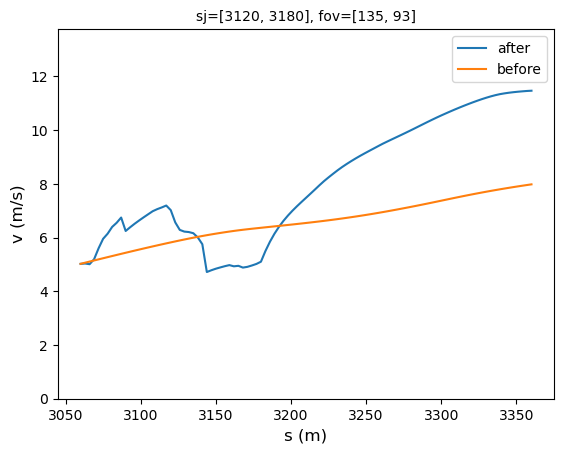

In [533]:
v_max = max(sol_realcar['v'])
plt.ylim(0, v_max * 1.2)  #上限设为最大值的120%
plt.plot(S,sol_realcar['v'], label='after')
plt.plot(S,df_sub['v'].to_numpy(), label='before')
plt.legend(loc='upper right', fontsize=10)
plt.title('sj=[3120, 3180], fov=[135, 93]', fontsize=10)
plt.xlabel('s (m)', fontsize=12)
plt.ylabel('v (m/s)', fontsize=12)
filename='sj=[3120, 3180], fov=[135, 93]'
plt.savefig(filename, dpi=300)  # dpi=300 适合高质量打印
plt.show()